# Model Evaluation

In this notebook, we will evaluate our trained model using various metrics and visualizations.

Lets first load and split the dataset again.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

processed_path = "../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)

df['label'] = df['polarity'].map({1: 0, 2: 1})

X = df['cleaned_review']
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42, stratify = y_train)

mac_vocab = 4000
maxlen = 70

Next step as part of the model evaluation is to load the best model. In the model training notebook, we utilized the ModelCheckpoint callback during training to automatically save the best model at some monitored metric. Loading the best model will ensure we have the version that generalizes best on validation data.

In [4]:
from tensorflow.keras.models import load_model

best_model = load_model('../models/cnn/best_model.keras')

Now we prepare the test data, by converting the raw test text data into numerical sequences using the same tokenuzer that was used during training, then pad these sequences to the fixed length (maxlen). This is to ensure consistency, as the model was trained on tokenized and padded data, we must process the test data the exact same way to get comparable results.

In [5]:
#importing tokenizer from previous notebook using pickle
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


from tensorflow.keras.preprocessing.sequence import pad_sequences

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')


Lets evaluate the model on the test set to see how well it performs

In [6]:
#evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(X_test_pad, y_test)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7978 - loss: 0.6292 
Test Accuracy: 0.7870
Test Loss: 0.6282


 # Generate detailed performance matrics

Now we'll create additional evaluations such as a confusion matrix and a classification report, including precision, recall and F1-score. Accuracy/loss alone might not capture the full picture of performance. Our model is so far fine, but detailed metrics might identify areas where the model might be misclassifying classes (along with showing where it performs well in some areas).

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_probs = best_model.predict(X_test_pad)
y_pred = (y_pred_probs >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       539
           1       0.77      0.77      0.77       461

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000


Confusion Matrix:
[[433 106]
 [107 354]]


To visualize the evaluation results, we'll  plot the confusion matrix using a heatmap, and visualize the ROC curve. Visualizations will provide insights into the models performance and highlight the specific types of errors.

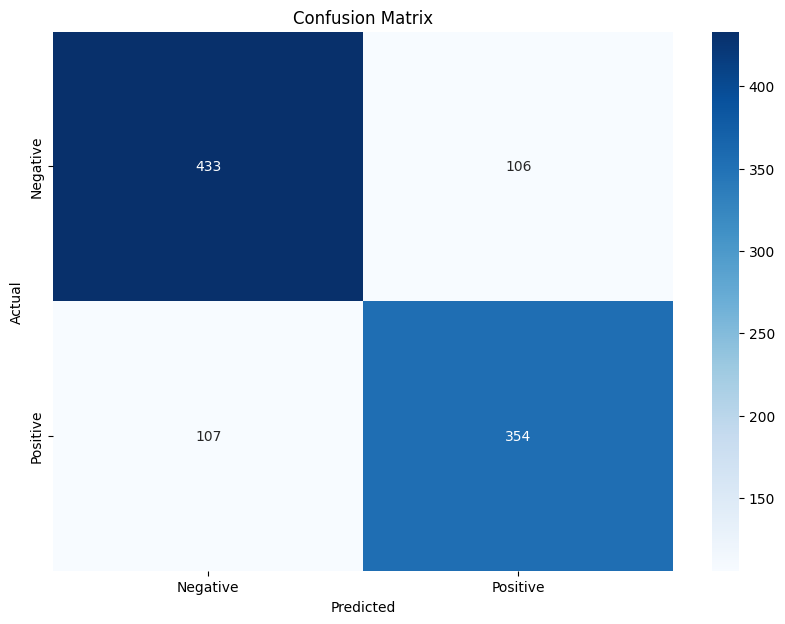

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


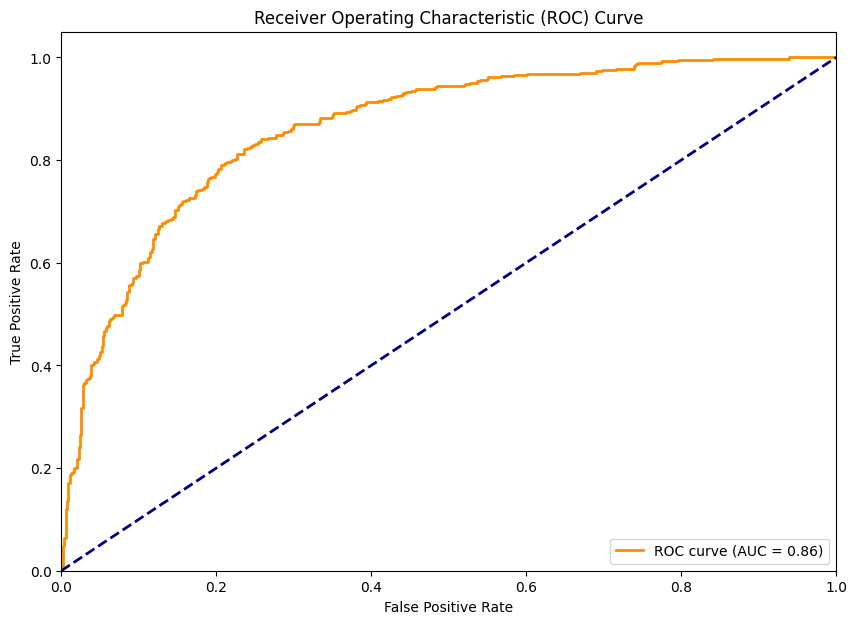

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#plot ROC curve
from sklearn.metrics import roc_curve, auc

#this gets the predicted probabilities for each test sample and flattens the array
y_pred_probs = best_model.predict(X_test_pad).ravel()

#calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
#calculate AUC (area under the curve)
roc_auc = auc(fpr, tpr)

#plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#ADDITIONALLY CAN PLOT A PRECISION-RECALL CURVE IF I WISH


An AUC of 0.86 indicates a reasonably strong ability to discriminate between positive and negative classes. 

AUC = 1.0: The model perfectly separates positive and negative classes
AUC = 0.8-0.9: Very good model
AUC = 0.7-0.8: Good model
AUC = 0.6-0.7: Fair model
AUC = 0.5-0.6: Poor model
AUC < 0.5: Worse than random guessing